In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss
import fastai.callbacks.hooks
from sklearn.metrics import roc_auc_score

In [3]:
path = Path("histo")

In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)
data = (ImageItemList.from_csv(path,csv_name="train_labels.csv",folder="train",suffix=".tif")
                     #.filter_by_rand(0.05)
                     .random_split_by_pct(0.2)
                     .label_from_df()
                     .transform(tfms,size=96)
                     .databunch(bs=32,num_workers=0)
                     .normalize(imagenet_stats))

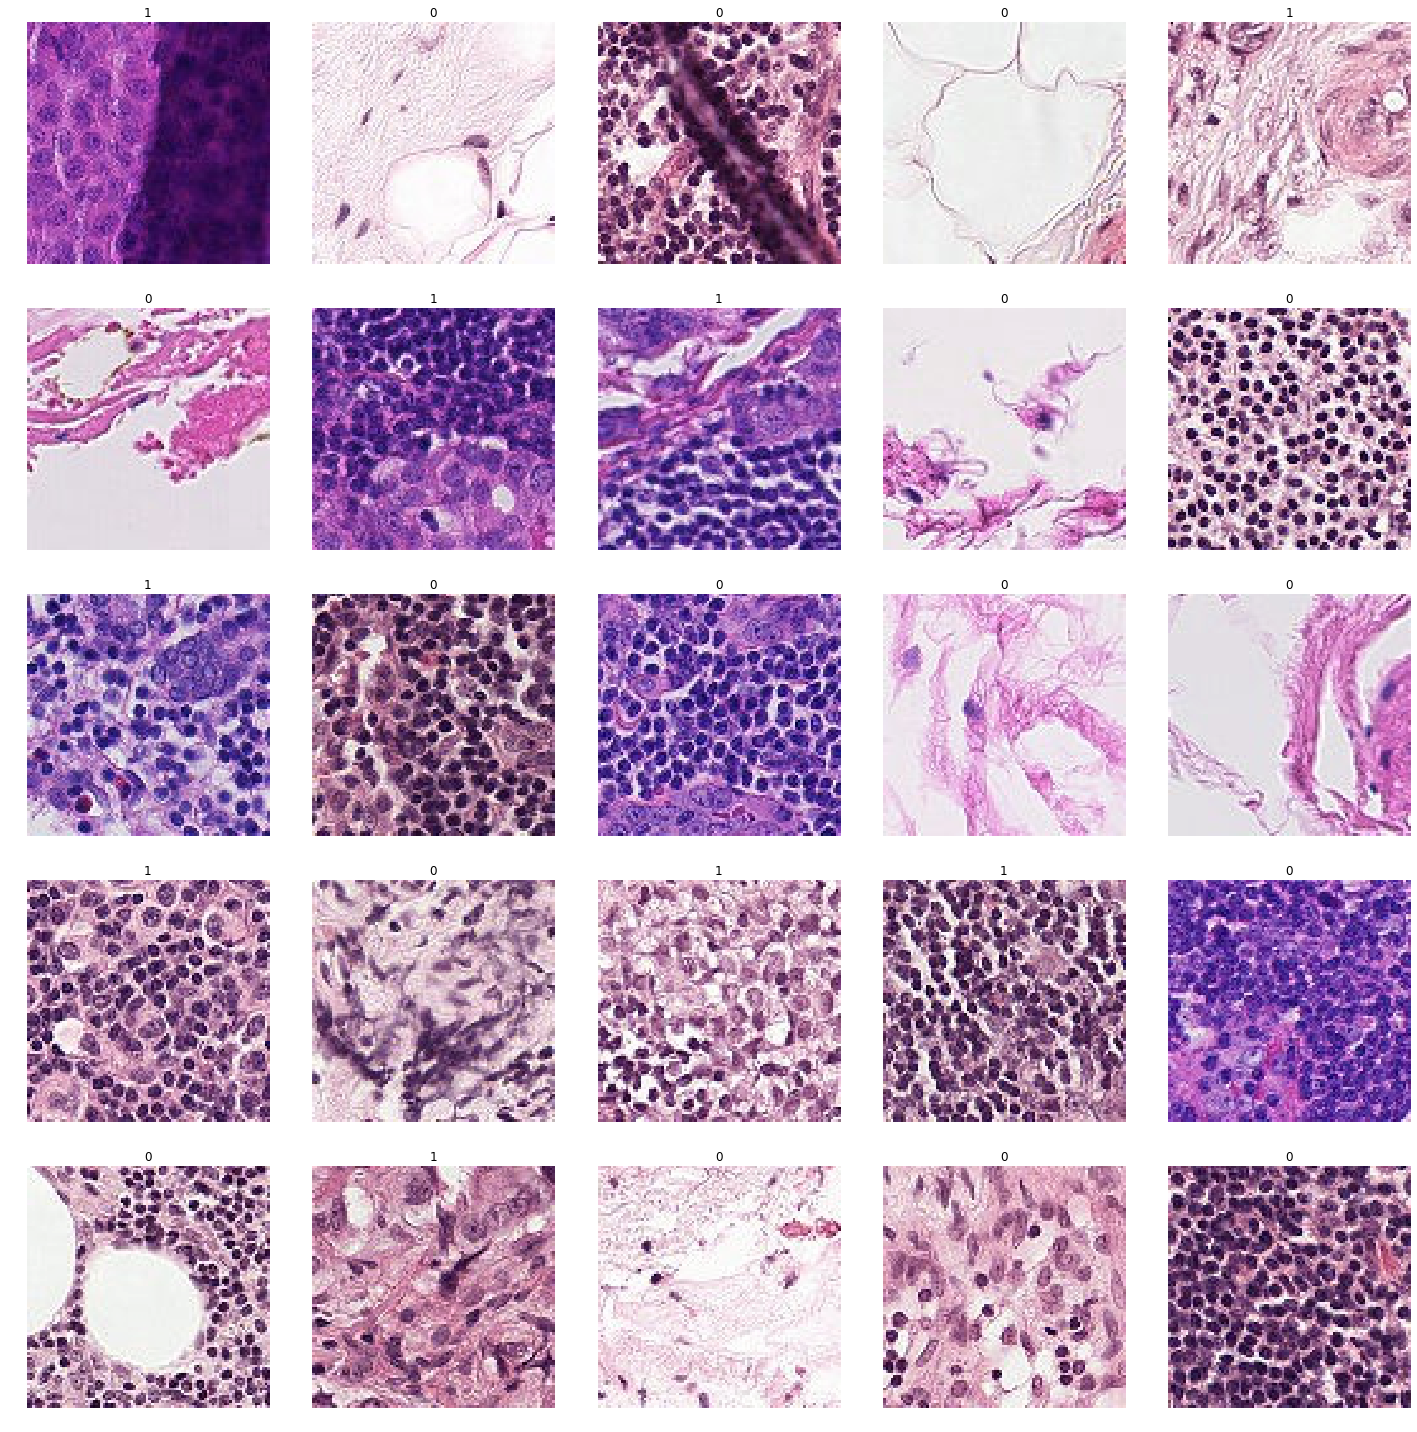

In [5]:
data.show_batch()

In [6]:
class ParallelAlex(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.hero = create_body(models.alexnet,pretrained=True)
        self.parallel = create_body(models.alexnet,pretrained=False)
        self.classifier = create_head(512 * 2,num_classes)
        
    def forward(self, x):
        x = torch.cat([self.hero(x),self.parallel(x)],dim=1)
        return self.classifier(x)

In [8]:
class SidekickAlexNet(nn.Module):
    def __init__(self, num_classes=1000,width=8,pretrained=True):
        super().__init__()
        
        self.hero = create_body(models.alexnet,pretrained=pretrained)
        ml = [f for i,f in enumerate(next(self.hero.children()).children()) if i in [2,5,7,9,12]]
        self.hooks = fastai.callbacks.Hooks(ml,lambda m,i,o: o,detach=False)
        
        self.features = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(3, 8*width, kernel_size=11, stride=4, padding=2),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(nn.Conv2d(8*width + 64, 24 * width, kernel_size=5, padding=2),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(nn.Conv2d(24*width + 192, 48 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(48*width + 384, 32 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(32*width + 256, 32 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2))])
        
        self.classifier = create_head((32*width + 256)*2,num_classes)

    def forward(self, x):
        bs = x.shape[0]
        pt = self.hero(x)
        
        x = self.features[0](x)
        for f, a in zip(self.features[1:],self.hooks.stored):
            x = f(torch.cat([x,a],dim=1))
            
        x = torch.cat([x,pt],dim=1)    
        x = self.classifier(x)
        return x


In [9]:
def logloss(preds,target):
    preds = torch.softmax(preds,dim=1)
    preds = preds.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    return torch.tensor(log_loss(target,preds))

In [10]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [11]:
learn = create_cnn(data,models.alexnet,metrics=[accuracy,auc_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


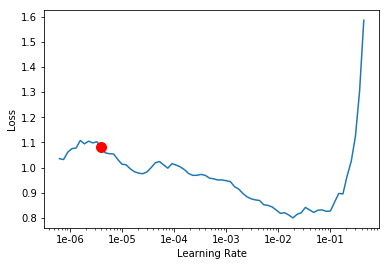

In [55]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.freeze()

In [13]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.417569,0.383978,0.828974,0.896115
2,0.448120,0.396222,0.826565,0.901346
3,0.455047,0.419776,0.810817,0.899514
4,0.450740,0.974083,0.817407,0.893441
5,0.442735,0.444423,0.821520,0.895273
6,0.426826,0.728458,0.813317,0.896755
7,0.415392,0.393759,0.827429,0.905863
8,0.421061,0.381950,0.836996,0.908086
9,0.410502,0.390296,0.839336,0.910504
10,0.411133,0.397215,0.840086,0.911690


In [14]:
learn.save("histo10")

In [62]:
learn.unfreeze()
learn.fit_one_cycle(20,1e-5)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.408642,0.377525,0.837500,0.377525
2,0.414084,0.406759,0.828125,0.406759
3,0.391770,0.476167,0.846875,0.464803
4,0.418910,0.345997,0.856250,0.345997
5,0.424500,0.373895,0.831250,0.373895
6,0.395468,0.377928,0.834375,0.377928
7,0.397927,0.421593,0.825000,0.421593
8,0.395696,0.369018,0.809375,0.369018
9,0.389232,0.345426,0.834375,0.345426
10,0.387360,0.364811,0.828125,0.364811


In [13]:
learnSK = Learner(data,SidekickAlexNet(data.train_ds.c,width=8),metrics=[accuracy,auc_score])
learnSK.split([learnSK.model.hero,learnSK.model.features[0],learnSK.model.classifier])

In [14]:
learnSK.model(next(iter(data.train_dl))[0]).shape

torch.Size([32, 2])

In [15]:
learnSK.freeze_to(1)

In [16]:
learnSK.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.315122,0.287720,0.878605,0.943712
2,0.299859,0.261700,0.893444,0.955778
3,0.274264,0.253975,0.904374,0.960216
4,0.270382,0.244891,0.906579,0.960410


KeyboardInterrupt: 

In [233]:
learnSK.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.284849,0.276237,0.884375,0.276237
2,0.282412,0.257992,0.893750,0.257992
3,0.299819,0.301946,0.865625,0.301946
4,0.287698,0.279168,0.865625,0.279168
5,0.290097,0.259174,0.896875,0.259174
6,0.275068,0.263316,0.893750,0.263316
7,0.278090,0.272048,0.903125,0.272048
8,0.298130,0.253138,0.896875,0.253138
9,0.292686,0.270719,0.900000,0.270719
10,0.262324,0.261731,0.896875,0.261731


In [ ]:
learnSK.save("sz128")

In [224]:
learnP = Learner(data,ParallelAlex(data.train_ds.c),metrics=[accuracy,logloss])
learnP.split([learnP.model.hero,learnP.model.parallel,learnP.model.classifier])

In [225]:
learnP.freeze_to(1)

In [226]:
learnP.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.556228,0.517807,0.743750,0.517807
2,0.457587,2.601780,0.553125,2.601781
3,0.443389,0.487029,0.746875,0.487029
4,0.426558,0.467504,0.756250,0.467504
5,0.452909,0.995536,0.575000,0.995536
6,0.443796,0.501301,0.778125,0.501301
7,0.423956,0.367492,0.828125,0.367492
8,0.438929,0.414534,0.771875,0.414534
9,0.412402,1.800288,0.559375,1.800288
10,0.412454,0.346541,0.834375,0.346541


In [227]:
learnP.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.374677,0.345647,0.825000,0.345647
2,0.347925,0.302350,0.846875,0.302350
3,0.361515,0.337443,0.840625,0.337443
4,0.346335,0.300358,0.853125,0.300358
5,0.371964,0.463704,0.759375,0.463704
6,0.368361,0.408657,0.815625,0.408657
7,0.348326,0.354264,0.834375,0.354263
8,0.361991,0.324385,0.865625,0.324385
9,0.349180,0.313714,0.856250,0.313714
10,0.350429,0.294424,0.875000,0.294424
